# Final Report: Modelling The Pandemic 
### (Group: Bored Grads Yacht Club)
Link to this notebook: https://github.com/uic-cs418/cs418-spring22-bored-grad-yacht-club/blob/main/CS418_final_report.ipynb

## Introduction
Our data science term project aims to model the impact of COVID-19 in Chicago areas, using sociodemographic data (age, income, education etc.) and COVID-19 statistics (hospitalizations, deaths etc.). The sociodemographic and COVID-19 data used here is for each ZIP code within Chicago. An existing COVID-19 model, the CCVI score, ranks neighborhoods in Chicago by vulnerability based on several sociodemographic factors, and develops an overall vulnerability score for each neighborhood based on these rankings. An issue with this ranking system is that the difference in factors is not accurately reflected by a difference in ranks; for example, two neighborhoods could have a relatively big difference in income but only be a rank apart, and vice versa (relatively small difference in income and a rank apart). The ranking-based score would normalize all differences in sociodemographic factors when calculating the vulnerability score, which could be a potential issue when deciding on how to accurately and precisely distribute resources to areas based on their COVID-19 vulnerability. Our model seeks to improve upon the CCVI score by assessing areas in a more absolute way, such that it can predict COVID-19 risk of an area in terms of cases, hospitalizations or deaths, given the sociodemographic factors of that area. We chose to develop the model for Chicago both because of our proximity to the city, and because Chicago has been a big COVID-19 hotspot in America during the last two years. Being a big, densely populated city, Chicago has had 567,470 COVID-19 cases, 41,694 hospitalizations and 7,635 deaths as of today. Despite these high numbers, the impact of COVID-19 has been unevenly distributed over the city of Chicago, and is primarily dictated by the sociodemographic factors that we are inspecting in our project. Since our model aims to predict COVID-19 impact from sociodemographic data, it can potentially help organizations distribute resources, healthcare and vaccination efforts in the city more accurately, as well as help policy-makers understand how the pandemic impact is affected by disparities in the city, and plan accordingly in the future to remedy this. One setback to our initial idea was that, Chicago only has 58 zipcodes. Having only 58 data instances was not sufficient to get good results on our predictive model. To resolve this issue, we added zipcode based Covid and sociodemographic data from various other cities (For ex: New York, San Antonio, etc.).

## Data Collection & Wrangling

Following are the sources of the original data files:
- Covid case/death related data:
    - Chicago: https://data.cityofchicago.org/browse?limitTo=datasets&sortBy=alpha&tags=covid-19
    - New York: https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv
    - San Antonio: https://cosacovid-cosagis.hub.arcgis.com/datasets/CoSAGIS::covid19-deaths-by-zip-code/about
    - Wisconsin: https://data.dhsgis.wi.gov/datasets/wi-dhs::covid-19-data-by-zip-code-tabulation-area-v2/about
    - North Carolina: https://www.newsobserver.com/news/coronavirus/article244546087.html
    - San Francisco: https://data.sfgov.org/COVID-19/COVID-19-Cases-and-Deaths-Summarized-by-ZIP-Code-T/tef6-3vsw/data
    - Montgomery County (MD): https://opendata.maryland.gov/Health-and-Human-Services/MD-COVID-19-Cases-by-ZIP-Code/ntd2-dqpx & https://www.montgomerycountymd.gov/covid19/data/case-counts.html#zip-code
    <br> <br>

- Sociodemographic data:
    - https://censusreporter.org/profiles/86000US60607-60607/ (collected via web scraping for all zipcodes)

Data wrangling is done in wrangleFinal.py file. The following steps were performed to clean the dataset.
- We collected Covid death and case related data for individual zipcodes. However, sociodemographic data was available for individual counties or census tracts. To match granularity, we scraped zipcode based Sociodemographic data from CensusReporter website. An example of how the sociodemographics data looks like can be seen here: https://censusreporter.org/profiles/86000US60607-60607/.
- For Chicago, there were few Covid death related data instances where 'Manner of Death' was 'ACCIDENT' or 'SUICIDE'. We removed those instances.
- Chicago's zipcode based boundary data was collected from Chicago Data Portal (later used for visualizing impact of Covid on individual zipcodes of Chicago). There were some instances in both Covid death and case related data where the zipcode was found to be outside Chicago. We removed those instances.
- Converted the date columns to datetime type. 
- Removed unneeded columns from both Covid case and death datasets.
- Aggregated Covid deaths and cases for all the zipcodes.
- Merged Covid deaths and cases with Sociodemographic data.
- Normalized Covid deaths and cases by each zipcode's population (ie: case per 1,000 / death per 1,000). Rounded the values to two decimal points.
- The cleaned datasets are stored in three separate files: 
    - Only Chicago data: "Chicago-Covid-SocioDemographics-Cases-Deaths.csv"
    - Additional data (NY, SA, WI, NC, SF, MD) for better predictive modeling: "AdditionalData-Covid-SocioDemographics-Cases-Deaths.csv"
    - All data: "AllData-Covid-SocioDemographics-Cases-Deaths.csv"
- Dataset wrangling operation can be performed by importing wrangleFinal python script and then calling the functions getChi(), getNew() or allData().

In [1]:
from wrangleFinal import *
chi = getChi() # Only Chicago's data. Total 58 instances
ny = getNY()   # Only New York's data. Total 
new = getNew() # Later added data: NY, SA, WI, NC, SF, MD
allData = getAllData(chi, new) # All data. Total 1,853 instances

## EDA/Visualization

In [2]:
from visFinal import *

##### Data Granularity and Data Scope
Each data instance in the cleaned dataset represents sociodemographic and covid impact of an individual zipcode. Initially, we started working with Chicago's data. However, to create a better predictive model, we later added data from several other major cities in US.

In [3]:
allData.head()

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Death Counts,Death Counts(Per 1000),Case Counts,Case Counts(Per 1000)
0,60647,85658,32.2,17.56,75.14,7.30,49.75,50.25,48.50,4.72,...,14.76,14.11,1.67,0.68,66.31,2.47,184.0,2.148077,17196.0,200.751827
1,60639,88515,34.6,26.29,62.24,11.47,49.90,50.10,8.07,13.24,...,4.69,2.99,0.61,0.00,91.67,0.03,278.0,3.140711,24130.0,272.609162
2,60707,42434,40.0,21.06,63.60,15.33,47.33,52.67,46.85,6.63,...,42.45,11.93,0.98,0.00,44.29,0.34,130.0,3.063581,4235.0,99.802046
3,60622,52957,32.2,13.41,79.84,6.75,50.64,49.36,64.44,5.35,...,38.17,19.04,1.60,0.50,38.03,2.65,89.0,1.680609,11074.0,209.113054
4,60651,63679,33.9,26.37,61.38,12.25,46.37,53.63,5.00,53.02,...,1.55,2.46,0.89,0.00,94.89,0.21,182.0,2.858085,14030.0,220.323812


##### Time series plot of Covid daily deaths and cases in Chicago
(Here, one interesting finding was that the Omicron variant hit really hard in Chicago. In the beginning of 2022, number of cases nearly rose to 50,000 per day which was far more than the initial Covid outbreak.)

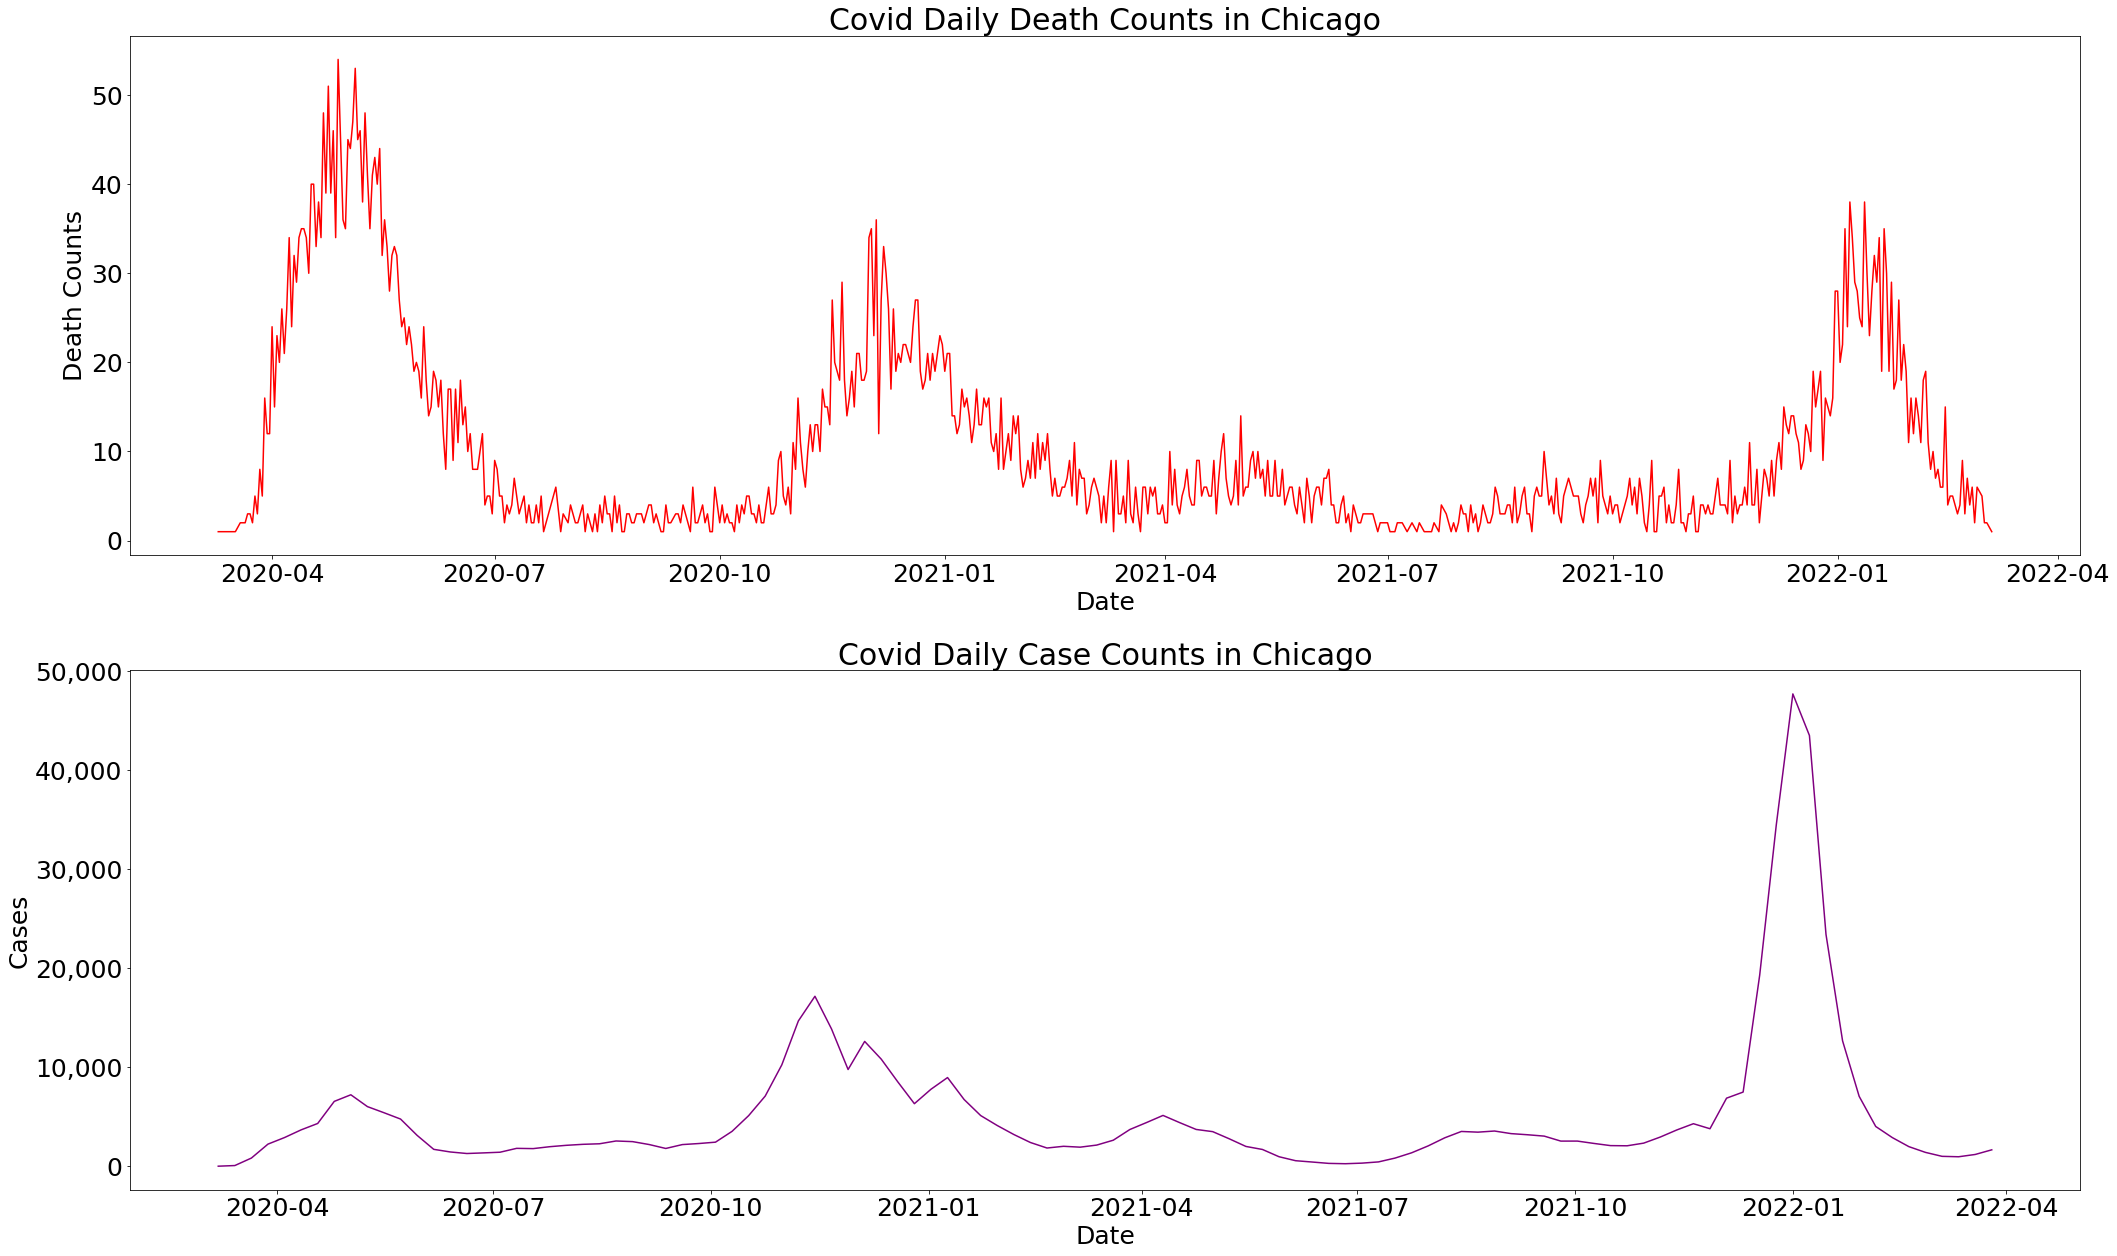

In [4]:
lineChart()

##### Covid cases and death rates in Chicago neighborhoods
- (Here, we find out that the neighborhood with zipcode 60604 had the most number of covid cases per 1,000 population. Digging deep we found out that, it's a very small neighboorhood with a population of 749 whereas it had 334 covid cases over the course of last two years. Neighborhoods with zipcode 60707 and 60827 had the least number of covid cases. In case of death rates, the neighborhoods most affected are of zipcodes 60621 and 60649.)
- One other interesting observation was that, wrt Covid death rates Chicago south side is more affected than the north.

In [5]:
chi[chi.Zipcode==60604][['Zipcode', 'Population', 'Case Counts', 'Case Counts(Per 1000)', 'Death Counts(Per 1000)']]

,Zipcode,Population,Case Counts,Case Counts(Per 1000),Death Counts(Per 1000)
27,60604,729,334,458.161866,2.743484


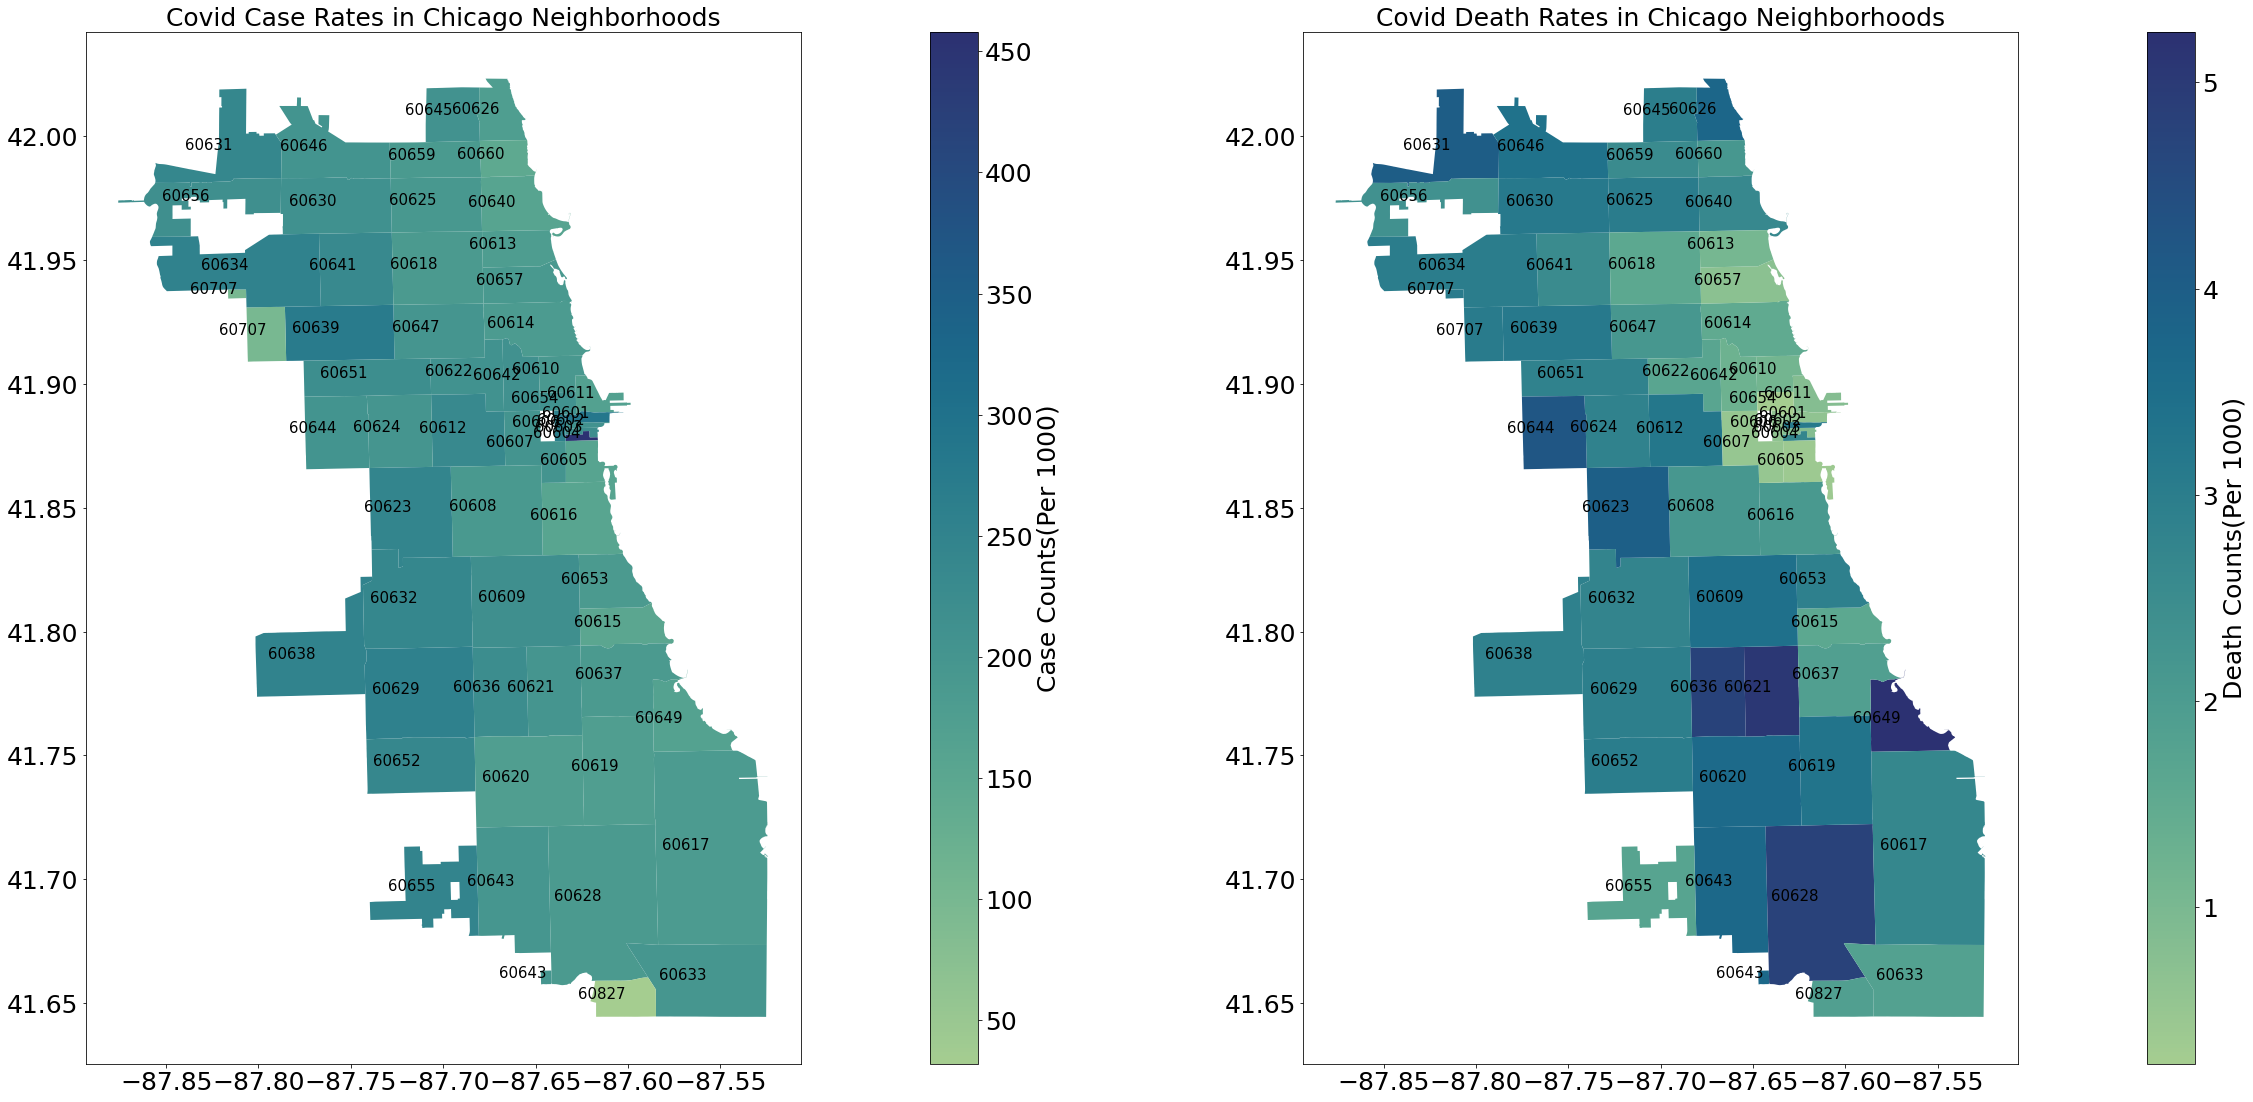

In [6]:
geographicPlot(chi)

##### Scatter Plot showing correlation between sociodemographic factors and Covid death cases
(As median household income, per capita income or median housing value of a neighboorhood increase, death counts per 1000 population decreases with some exceptions. Meaning, there is some correlation with economic standing of a neighboorhood and the impact of Covid 19.)

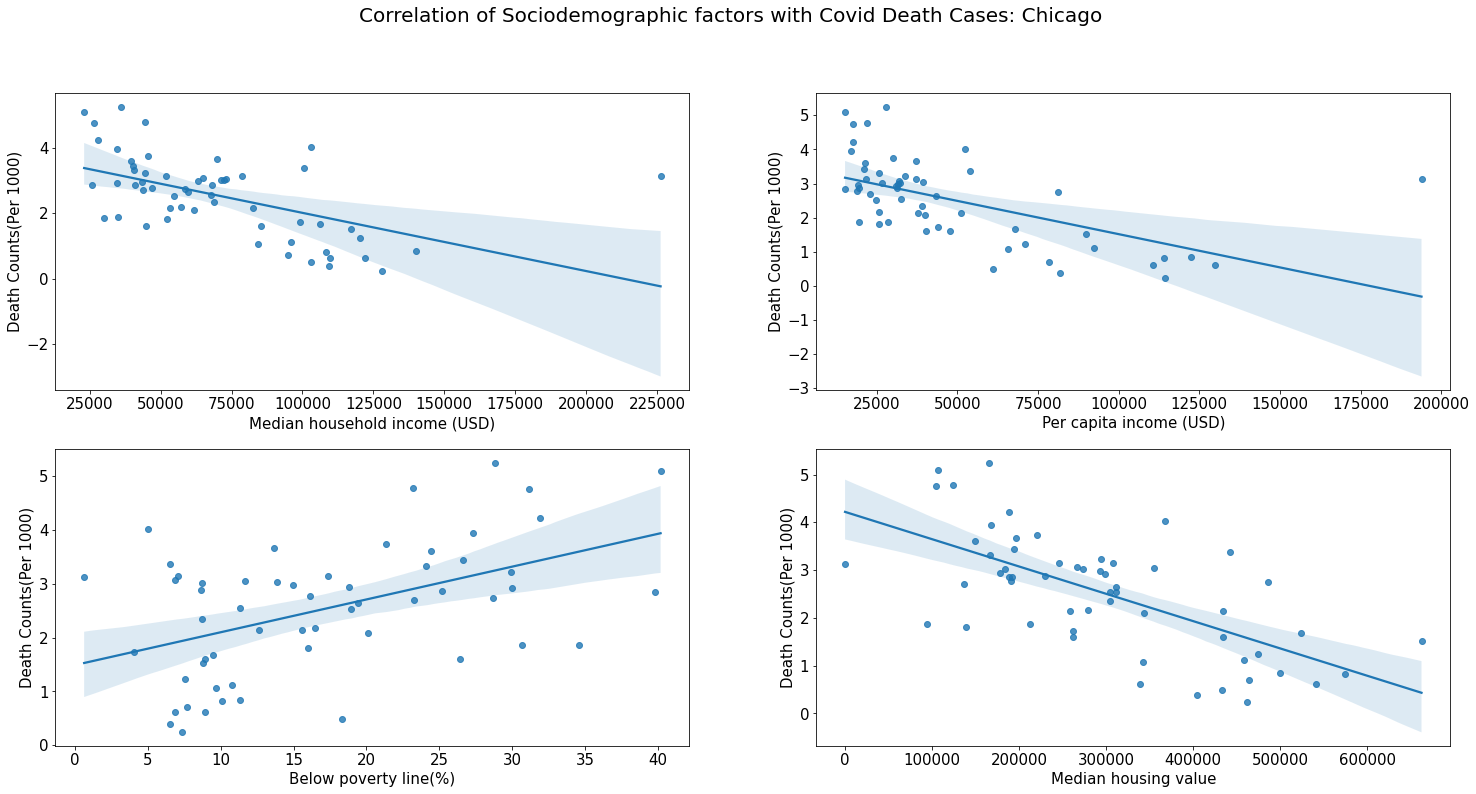

In [7]:
scatterPlot(chi, "Chicago")

##### Variability in Sociodemographic Factors wrt Geographic Region
Some of the sociodemographic factors heavily varies with respect to geographic region. For example, if we look at the merged data on left, we'll be unable to find any correlation between covid deaths and median household income. However, if we look at New York or Chicago's data separately, there is clear correlation between covid related deaths and median household income. Thus, our predictive model will also have some variablity issue, but the overall improved results overweights this.

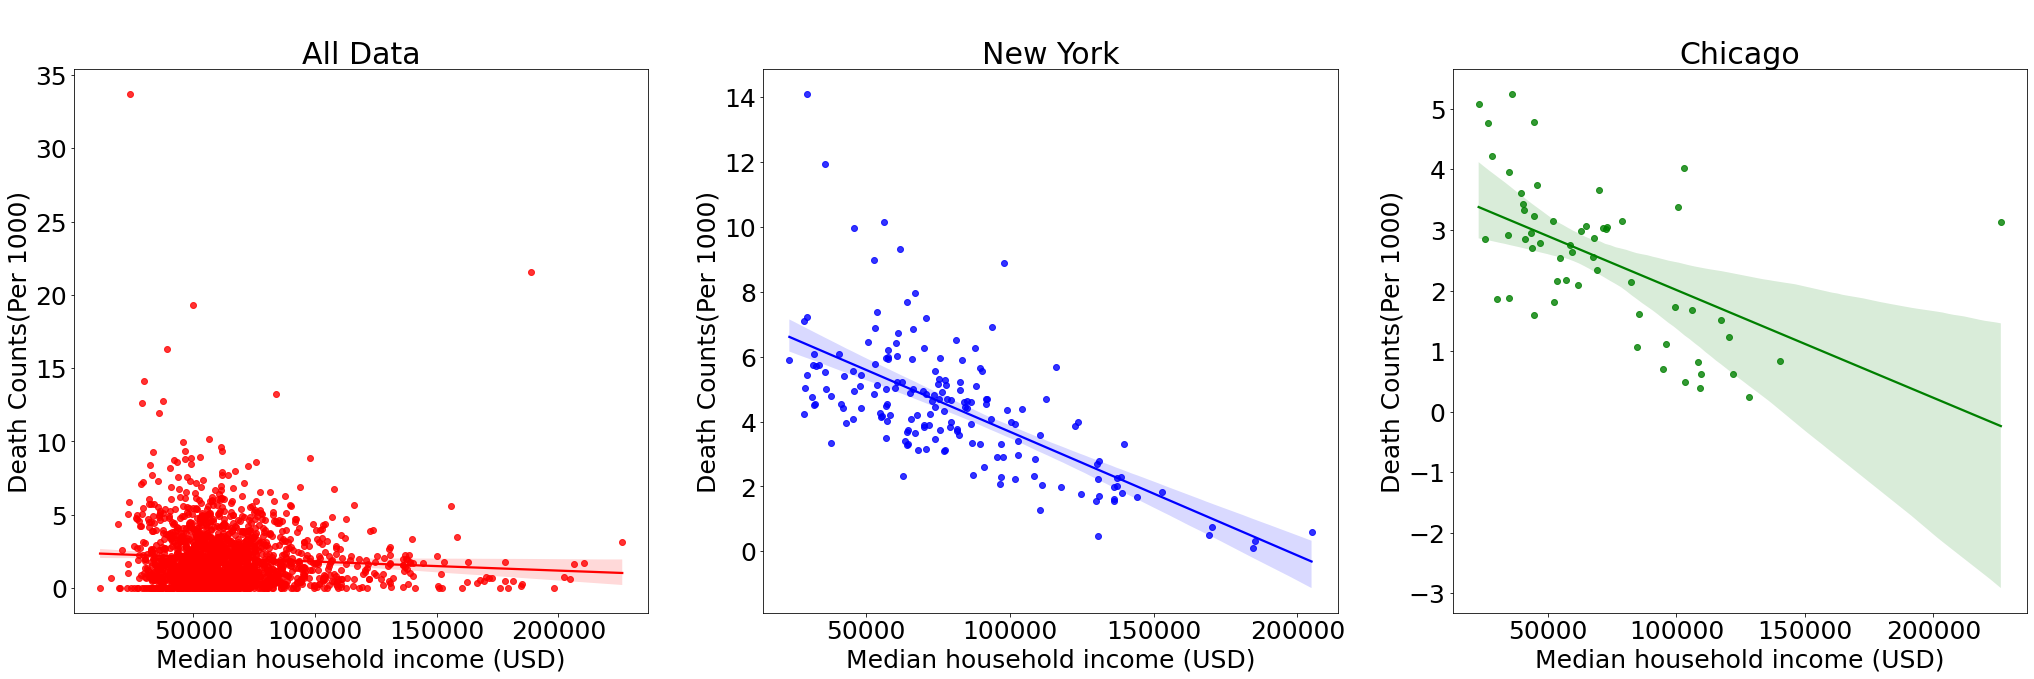

In [8]:
scatterPlotComp(allData, ny, chi)

##### Bar plot showing feature importance of sociodemographic factors with Covid death cases
(Here, we plotted the correlation of Covid death cases with sociodemographic features. [Note: features with correlation less than 0.1 are discarded])

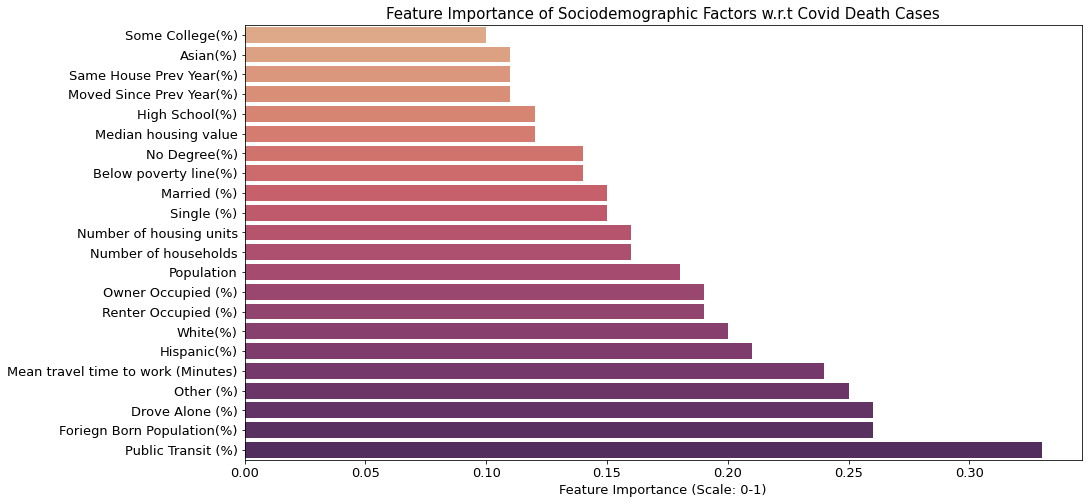

In [9]:
featureImportance(allData,0.1)

## ML/Stats


#### Random forest regression model

We used a random forest regression (RFR) model to predict COVID-19 deaths per capita as a function of sociodemographic variables in each zipcode. The RFR was poor at predicting extreme values (death rates that were either zero or much higher than usual). Therefore, the final model is trained on data filtered to remove zipcodes with death rates of either zero or greater than the 95th percentile. This resulted in a training error rate of 0.29 deaths per thousand people and a test error rate of 0.73 deaths per thousand people. We used the median death rate from the training data as a baseline, resulting in a baseline training error 0f 1.18 deaths per thousand and a baseline training error of 1.11 deaths per thousand.

A few alternate versions of this model were tested, including predicting log-transformed death rates, training the model using the principal components matrix below, and analyzing zipcodes within major urban centers separately from the others. The model with the lowest absolute error is shown here. 

Mean absolute training error (deaths per thousand):  0.2909724872341416
Mean absolute test error (deaths per thousand):  0.7754497036732297


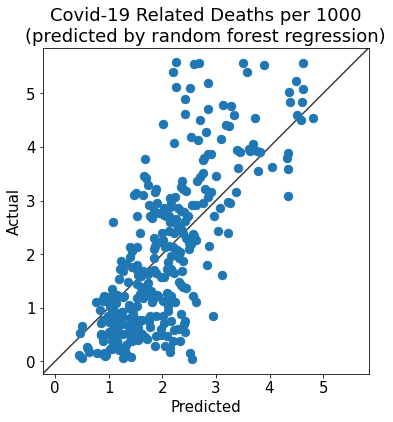

In [10]:
from rf_analysis import *
rfr = rf_analysis(plot=True)

#### XGBoost model
(Text here: Gautam)

 
Mean absolute training error (deaths per thousand):  0.12708722250862267
Mean absolute test error (deaths per thousand):  0.9840386148467551


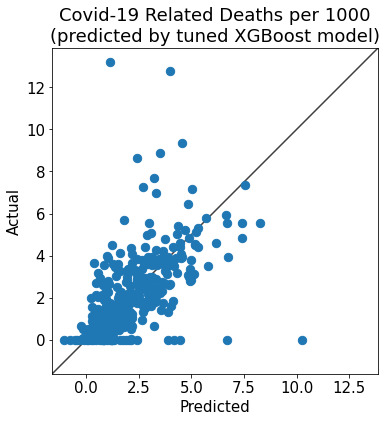

In [11]:
from xgBoost_analysis import *
xgBoost_analysis()

#### Principal components analysis

We also performed principal components analysis (PCA), in order to help visualize the distribution of COVID-19-related death rates in the multivariate sociodemographic dataspace. (Note: as an unsupervised learning technique, there is no baseline to compare the PCA to. That is why a baseline comparison is not discussed here.)

In order to maintain separation of training and testing partitions formed above, only the training data was used for this analysis. The first two principal components, which together account for 39.89% of total variance between zipcodes, are visualized below. Each point on the plot represents one zipcode, and points are colored by the number of COVID-19-related deaths per 1,000 people in that zipcode. 

Unlike with the PCA visualization of Chicago data alone that we visualized in our progress report, there is not an obvious pattern in the distribution of death rates over the first two principal components. One reason for this may be that the zipcodes represented here include several different types of areas (e.g., rural, urban, and suburban) and the relationship between sociodemographic variables and COVID-19 death rates may not be consistent across all of these areas. 

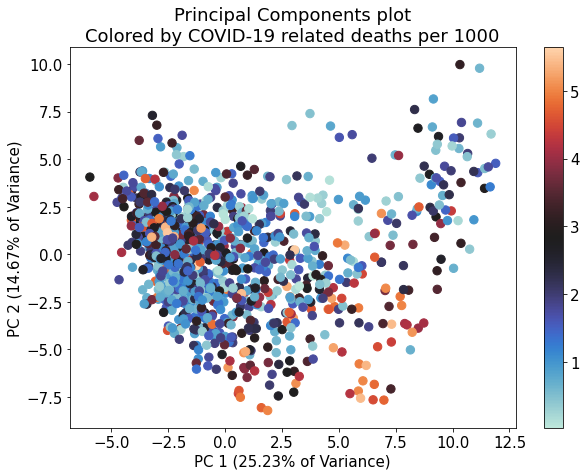

In [12]:
from PCA_analysis import *
pca_analysis()

## Results
- Cleaned dataset containing zipcode based Covid 19 and sociodemographic data of Chicago, New York, San Francisco, San Antonio, North Carolina, Wisconsin, etc. (Total 1,853 data instances)
- Initial exploration and visualization of Covid-19 impact in Chicago.
- Visualization of correlation between Covid-19 and sociodemographic factors.
- Visualization of how these correlations vary with different geographic regions.
- Visualization of important socodemographic factors with respect to COVID-19 mortality rate.

Previously, the problem that we were facing was that the data from Chicago had 60 zipcodes. Thus, there was not enough data points to train an accurate model to predict the vulnerability. We resolved this issue by collecting zipcode based Covid and sociodemographic data from various other cities (For ex: New York, San Antonio, etc.) resulting in a dataset with 1,853 instances. However, some of the sociodemographic factors varied a lot with different geographic regions which had some impact on the ML model.

--- ***Christopher*** ADD insights from ML, PCA and also the drawbacks